# Wildfire Spread Simulation: Pará, BR, Deforestation Frontier

## Scenario Overview

I'm modeling wildfire spread in the **Pará deforestation frontier** in the Brazilian Amazon. This region features a heterogeneous landscape with patches of dense rainforest adjacent to cleared/degraded areas — creating a characteristic deforestation pattern typical of Amazonian agricultural expansion.

**Study Area:** ~3×3 km² grid (100×100 cells at 30m resolution) near (-7.27°S, -49.61°W)

**Data:** Hansen Global Forest Change dataset (2000), 30m resolution pixels with tree density 0-100%.

**Goals:**
1. Build a risk map showing which cells are most likely to burn
2. Find the percolation threshold where fires transition from local to landscape-wide
3. Compare two fire management strategies and quantify their effectiveness

## 1. Setup and Data Loading

In [1]:
# Importing libraries
# - PIL: Image loading for GeoTIFF raster data
# - tqdm: Progress bars for long-running simulations
# - requests: HTTP requests to download Hansen dataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches
from PIL import Image
from tqdm.notebook import tqdm
import requests
import io
#!pip install rasterio
import rasterio
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(42)

Reading Hansen tile: 00N_050W
Extracted region shape: (108, 109)
Final grid: (100, 100) (3 km × 3 km at 30m resolution)


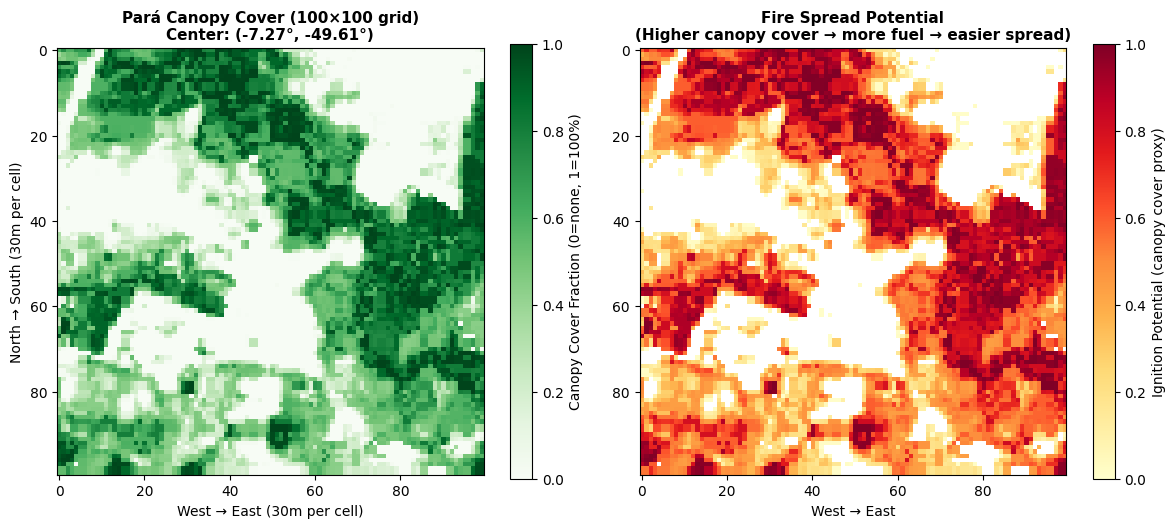

Landscape Composition (Pará 100×100 grid)
  Mean canopy cover: 0.42
  Non-forest (cover = 0):       28.0%  ← clearings, water
  Low cover (0 < c < 0.3):      14.3%  ← degraded/sparse
  Mid cover (0.3 ≤ c ≤ 0.7):    31.1%  ← secondary forest
  High cover (c > 0.7):         26.6%  ← primary forest


In [2]:
# DOWNLOAD AND PROCESS HANSEN GLOBAL FOREST CHANGE DATA
# Source: Hansen et al. (2013) Global Forest Change dataset [1]
# STUDY AREA DEFINITION
# Pará State, Brazilian Amazon, 3×3 km region in the deforestation frontier
# Coordinates: approximately -7.27°S, -49.61°W

lat_max = -7.25692 # Northern boundary
lat_min = -7.28386 # Southern boundary
lon_min = -49.62229 # Western boundary
lon_max = -49.59512 # Eastern boundary

lat_center = (lat_max + lat_min) / 2
lon_center = (lon_max + lon_min) / 2

# DOWNLOAD HANSEN TILE
# Tiles are named by their northwest corner
# Each tile is 40,000 × 40,000 pixels at 30m resolution = 10° × 10°
tile_name = "00N_050W"
tile_url = (
    "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/"
    f"Hansen_GFC-2019-v1.7_treecover2000_{tile_name}.tif"
)

print(f"Reading Hansen tile: {tile_name}")

with rasterio.open(tile_url) as src:
    # Calculate window from lat/lon bounds
    # Rasterio uses (row, col) = (y, x)
    px_per_deg = 4000
    tile_top_lat = 0
    tile_left_lon = -50
    row_start = int((tile_top_lat - lat_max) * px_per_deg)
    row_end   = int((tile_top_lat - lat_min) * px_per_deg)
    col_start = int((lon_min - tile_left_lon) * px_per_deg)
    col_end   = int((lon_max - tile_left_lon) * px_per_deg)
    window = rasterio.windows.Window(col_start, row_start, col_end-col_start, row_end-row_start)
    region = src.read(1, window=window)

# Normalize from 0-100% to 0.0-1.0
tree_density_full = np.clip(region / 100.0, 0, 1)
print(f"Extracted region shape: {tree_density_full.shape}")

# Crop to the 100 x 100 grid
H, W = tree_density_full.shape
if H < 100 or W < 100:
    raise ValueError(f"Extracted region too small: {H}×{W}. Need at least 100×100.")
r0 = (H - 100) // 2
c0 = (W - 100) // 2
tree_density = tree_density_full[r0:r0+100, c0:c0+100]
print(f"Final grid: {tree_density.shape} (3 km × 3 km at 30m resolution)")

# Visualize landscape and compute statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(tree_density, cmap="Greens", vmin=0, vmax=1)
axes[0].set_title(f"Pará Canopy Cover (100×100 grid)\nCenter: ({lat_center:.2f}°, {lon_center:.2f}°)", fontsize=11, fontweight='bold')
axes[0].set_xlabel("West → East (30m per cell)")
axes[0].set_ylabel("North → South (30m per cell)")
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label("Canopy Cover Fraction (0=none, 1=100%)")

risk_preview = tree_density.copy()
risk_preview[tree_density == 0] = np.nan
im2 = axes[1].imshow(risk_preview, cmap="YlOrRd", vmin=0, vmax=1)
axes[1].set_title("Fire Spread Potential\n(Higher canopy cover → more fuel → easier spread)", fontsize=11, fontweight='bold')
axes[1].set_xlabel("West → East")
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label("Ignition Potential (canopy cover proxy)")

plt.tight_layout()
plt.show()

zero_density = (tree_density == 0).mean() * 100
low_density  = ((tree_density > 0) & (tree_density < 0.3)).mean() * 100
mid_density  = ((tree_density >= 0.3) & (tree_density <= 0.7)).mean() * 100
high_density = (tree_density > 0.7).mean() * 100

print("Landscape Composition (Pará 100×100 grid)")
print(f"  Mean canopy cover: {tree_density.mean():.2f}")
print(f"  Non-forest (cover = 0):      {zero_density:5.1f}%  ← clearings, water")
print(f"  Low cover (0 < c < 0.3):     {low_density:5.1f}%  ← degraded/sparse")
print(f"  Mid cover (0.3 ≤ c ≤ 0.7):   {mid_density:5.1f}%  ← secondary forest")
print(f"  High cover (c > 0.7):        {high_density:5.1f}%  ← primary forest")

## 2. The Fire Spread Model

### How it works

This is a cellular automaton where each cell has one of three states:
- **TREE (0):** Has fuel, can catch fire
- **BURNING (1):** Currently on fire
- **BURNED (2):** Already burned, can't burn again

### Spread rules

Each timestep:
1. All BURNING cells become BURNED
2. For each TREE cell next to a burning cell, roll the dice to see if it catches fire

✓ FireSimulator class defined


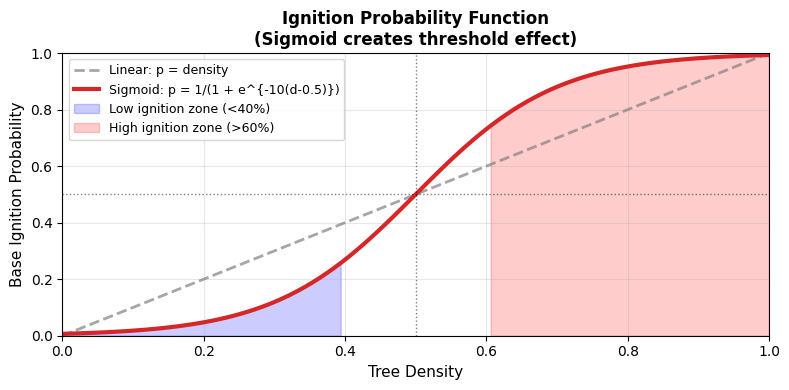


📊 Sigmoid interpretation:
 Below 40% density: fire struggles to spread (p < 0.27)
 Around 50% density: threshold region (p ≈ 0.5)
 Above 60% density: fire spreads readily (p > 0.73)
 Zero-density cells: never ignite (perfect firebreaks)


In [3]:
# FIRE SPREAD CELLULAR AUTOMATON MODEL
# This implements a stochastic cellular automaton for wildfire spread, following the
# general framework from percolation theory [2] and adapted for heterogeneous fuel
# landscapes based on CS166 course materials [3].
#
# Design choices:
# 1. Three cell states: TREE (fuel), BURNING (active fire), BURNED (consumed)
# 2. 8-neighbor connectivity (Moore neighborhood) for fire spread
# 3. Sigmoid ignition probability creates threshold effects
# 4. Wind modifies spread probability directionally
#
# References:
# [2] Stauffer & Aharony (1994) - Introduction to Percolation Theory
# [3] CS166 Course Materials - Modeling Complex Systems

# CELL STATE DEFINITIONS
TREE = 0 # Has fuel, can catch fire
BURNING = 1 # Currently on fire (active front)
BURNED = 2 # Already consumed, cannot burn again


class FireSimulator:
    """
    Cellular automaton simulator for wildfire spread on a heterogeneous landscape.

    The model uses Hansen canopy cover data as a proxy for fuel load and
    connectivity. Higher canopy cover means more biomass and easier fire spread.
    Fire spreads probabilistically to 8-neighbors with probability determined by:
    1. Local cover
    2. Wind direction and strength

    Based on percolation theory [2] and adapted from CS166 materials [3].

    Attributes
    ----------
    density : np.ndarray
        2D array of canopy cover values [0, 1] representing fuel load proxy
    wind_angle : float
        Wind direction in radians (0 = East, π/2 = North)
    wind_strength : float
        Wind intensity [0, 1] affecting directional spread bias
    grid : np.ndarray
        Current state of each cell (TREE, BURNING, or BURNED)
    time : int
        Number of simulation timesteps elapsed
    """

    def __init__(self, density, wind_dir=0, wind_strength=0.0):
        """
        Initialize the fire simulator with landscape and wind parameters.

        Parameters
        ----------
        density : np.ndarray
            Canopy cover map [0, 1] from Hansen dataset [1]. This represents canopy
            cover fraction.
        wind_dir : float
            Wind direction in degrees (0=East, 90=North, 180=West, 270=South)
        wind_strength : float
            Wind intensity [0, 1]. Higher values create stronger directional bias.
        """
        self.density = density.copy()
        self.rows, self.cols = density.shape
        self.wind_angle = np.radians(wind_dir)
        self.wind_strength = wind_strength
        self.grid = None
        self.time = 0

        # 8-neighbor (Moore neighborhood) connectivity with directional angles
        # Format: (row_offset, col_offset, angle_in_radians)
        # Angles represent direction from burning cell to neighbor
        self.neighbors = [
            (-1,  0,  np.pi/2), # N  (north)
            ( 1,  0, -np.pi/2), # S  (south)
            ( 0,  1,  0), # E  (east)
            ( 0, -1,  np.pi), # W  (west)
            (-1,  1,  np.pi/4), # NE (northeast)
            (-1, -1,  3*np.pi/4), # NW (northwest)
            ( 1,  1, -np.pi/4), # SE (southeast)
            ( 1, -1, -3*np.pi/4) # SW (southwest)
        ]

    def reset(self):
        """Reset the grid to initial state (all cells unburned)."""
        self.grid = np.zeros((self.rows, self.cols), dtype=int)
        self.time = 0

    def ignite(self, row, col):
        """Start fire at a specific cell location."""
        if 0 <= row < self.rows and 0 <= col < self.cols:
            self.grid[row, col] = BURNING

    def ignite_random(self):
        """
        Start fire at a random cell that has fuel (density > 0).
        This models uniform random ignition across the vegetated landscape.
        """
        fuel_cells = np.where(self.density > 0)
        if len(fuel_cells[0]) == 0:
            # No fuel anywhere, pick random cell (fire dies immediately)
            r = np.random.randint(self.rows)
            c = np.random.randint(self.cols)
        else:
            # Uniform random selection from cells with fuel
            idx = np.random.randint(len(fuel_cells[0]))
            r, c = fuel_cells[0][idx], fuel_cells[1][idx]
        self.grid[r, c] = BURNING

    def ignite_west_edge(self):
        """
        Ignite all fuel cells along the west edge. Used for percolation analysis.
        """
        for r in range(self.rows):
            if self.density[r, 0] > 0:
                self.grid[r, 0] = BURNING

    def calc_ignition_prob(self, row, col, angle_to_neighbor):
        """
        Calculate probability that a cell catches fire from a burning neighbor.

        The probability combines two factors:
        1. BASE PROBABILITY: Sigmoid function of canopy cover
           p_base = 1 / (1 + exp(-10 * (d - 0.5)))
           This creates a threshold effect at ~50% canopy cover [2, 3]

        2. WIND FACTOR: Directional modifier based on spread direction
           - Downwind (with wind): boosted up to 2.2x
           - Upwind (against wind): reduced to ~0.04x via squaring
           - Crosswind: minimal change

        Parameters
        ----------
        row, col: int
            Location of the target cell
        angle_to_neighbor: float
            Direction of spread in radians

        Returns
        -------
        float
            Ignition probability [0, 1]
        """
        d = self.density[row, col]

        # Zero-density cells don't ignite (water, bare ground, cleared land)
        if d <= 0:
            return 0.0

        # Sigmoid transformation creates threshold behavior
        # At d=0.3: p≈0.12, at d=0.5: p=0.50, at d=0.7: p≈0.88
        base_prob = 1 / (1 + np.exp(-10 * (d - 0.5)))

        # Wind effect: asymmetric directional bias
        # We use an asymmetric function because real fires spread much easier downwind than
        # upwind. The squaring for upwind creates the near-complete blocking effect
        # against the wind.
        if self.wind_strength > 0:
            angle_diff = angle_to_neighbor - self.wind_angle
            cos_val = np.cos(angle_diff)

            if cos_val >= 0: # Downwind or crosswind
                # Boost: max 2.2x with strength=0.8 directly downwind
                # Example: wind_strength=0.8, cos_val=1 → 1 + 0.8*1*1.5 = 2.2x
                wind_factor = 1 + self.wind_strength * cos_val * 1.5
            else: # Upwind
                # Strong penalty: squared reduction for realistic blocking
                # The squaring models the strong resistance to upwind spread
                # Example: wind_strength=0.8, cos_val=-1 (directly upwind)
                #   → (1 + 0.8 * -1)² = (0.2)² = 0.04x
                # This causes approx 25× reduction matches observed fire behavior where
                # upwind spread is rare except in extreme conditions
                wind_factor = max(0.02, (1 + self.wind_strength * cos_val) ** 2)
        else:
            wind_factor = 1.0

        return np.clip(base_prob * wind_factor, 0, 1)

    def step(self):
        """
        Execute one timestep of fire spread.

        Algorithm:
        1. All currently BURNING cells become BURNED (fire consumes fuel)
        2. For each burned cell, check all 8 neighbors
        3. If neighbor is TREE with fuel, roll dice against ignition probability
        4. Successful ignition changes neighbor state to BURNING

        Returns
        -------
        bool
            True if fire is still active (any burning cells remain)
        """
        new_grid = self.grid.copy()

        # Find all currently burning cells
        burning_rows, burning_cols = np.where(self.grid == BURNING)

        # Burning cells consume their fuel and become burned
        for r, c in zip(burning_rows, burning_cols):
            new_grid[r, c] = BURNED

        # Try to spread fire to each neighbor of each burning cell
        for r, c in zip(burning_rows, burning_cols):
            for dr, dc, angle in self.neighbors:
                nr, nc = r + dr, c + dc

                # Skip: out of bounds
                if not (0 <= nr < self.rows and 0 <= nc < self.cols):
                    continue
                # Skip: already burning or burned
                if self.grid[nr, nc] != TREE:
                    continue
                # Skip: no fuel
                if self.density[nr, nc] == 0:
                    continue

                # Stochastic ignition based on density and wind
                prob = self.calc_ignition_prob(nr, nc, angle)
                if np.random.random() < prob:
                    new_grid[nr, nc] = BURNING

        self.grid = new_grid
        self.time += 1

        # Return True if fire still active
        return np.sum(self.grid == BURNING) > 0

    def run(self, max_steps=1000):
        """
        Run simulation until fire dies naturally or hits max steps.

        Parameters
        ----------
        max_steps : int
            Safety limit to prevent infinite loops

        Returns
        -------
        int
            Number of timesteps until fire extinguished
        """
        while self.time < max_steps:
            if not self.step():
                break
        return self.time

    def burned_fraction(self):
        """
        Calculate fraction of vegetated area that burned.

        Returns
        -------
        float
            Proportion of fuel cells (density > 0) that are in BURNED state
        """
        total_fuel = np.sum(self.density > 0)
        if total_fuel == 0:
            return 0
        return np.sum(self.grid == BURNED) / total_fuel

    def did_span_horizontal(self):
        """
        Check if fire spanned from west edge to east edge.
        Used for percolation threshold analysis [2].

        Returns
        -------
        bool
            True if burned cells exist on both west (col 0) and east (col -1) edges
        """
        burned = (self.grid == BURNED)
        return burned[:, 0].any() and burned[:, -1].any()


print("✓ FireSimulator class defined")

# SIGMOID IGNITION PROBABILITY FUNCTION
# This shows how tree density maps to ignition probability
# The sigmoid creates a threshold effect around 50% density
d_vals = np.linspace(0, 1, 100)
p_linear = d_vals # Simple linear: p = density
p_sigmoid = 1 / (1 + np.exp(-10 * (d_vals - 0.5))) # sigmoid function

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_vals, p_linear, '--', color='gray', alpha=0.7, linewidth=2, label='Linear: p = density')
ax.plot(d_vals, p_sigmoid, '-', color='#D62728', linewidth=3, label='Sigmoid: p = 1/(1 + e^{-10(d-0.5)})')
ax.axvline(0.5, color='black', linestyle=':', alpha=0.5, linewidth=1)
ax.axhline(0.5, color='black', linestyle=':', alpha=0.5, linewidth=1)

# Add shaded regions to show threshold behavior
ax.fill_between(d_vals[d_vals < 0.4], 0, p_sigmoid[d_vals < 0.4], alpha=0.2, color='blue', label='Low ignition zone (<40%)')
ax.fill_between(d_vals[d_vals > 0.6], 0, p_sigmoid[d_vals > 0.6], alpha=0.2, color='red', label='High ignition zone (>60%)')

ax.set_xlabel('Tree Density', fontsize=11)
ax.set_ylabel('Base Ignition Probability', fontsize=11)
ax.set_title('Ignition Probability Function\n(Sigmoid creates threshold effect)', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n📊 Sigmoid interpretation:")
print(" Below 40% density: fire struggles to spread (p < 0.27)")
print(" Around 50% density: threshold region (p ≈ 0.5)")
print(" Above 60% density: fire spreads readily (p > 0.73)")
print(" Zero-density cells: never ignite (perfect firebreaks)")

## 3. Test the Simulation

Starting fire at (46, 53) with density 0.58
Fire lasted 95 steps
Burned 3799 cells (52.8% of landscape)


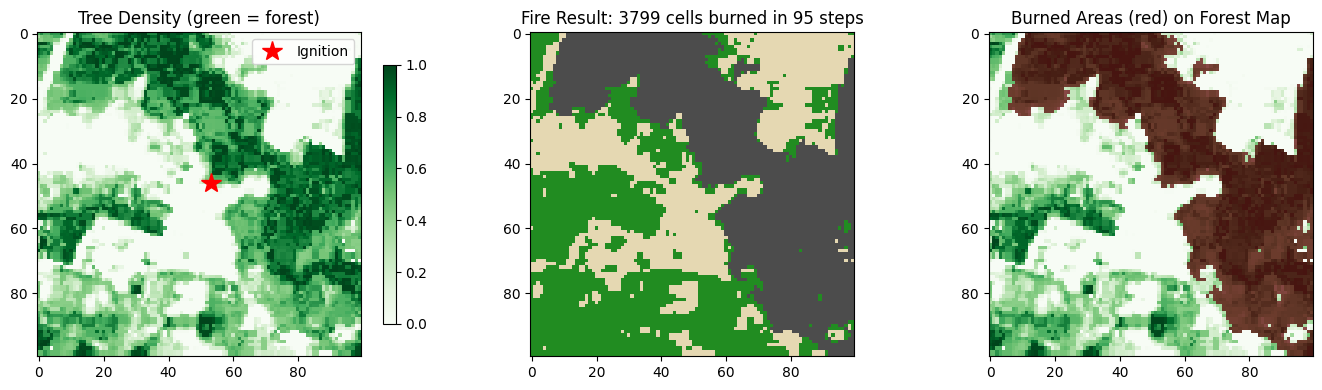

In [4]:
# Run one fire starting from a high-density cell to validate that the model works
# before running Monte Carlo

sim = FireSimulator(tree_density, wind_dir=0, wind_strength=0.5)
sim.reset()

# Find a cell with good fuel to start from (at least 50% density)
good_cells = np.where(tree_density > 0.5)
if len(good_cells[0]) > 0:
    # Pick one near the center
    center_r, center_c = tree_density.shape[0]//2, tree_density.shape[1]//2
    distances = (good_cells[0] - center_r)**2 + (good_cells[1] - center_c)**2
    best_idx = np.argmin(distances)
    start_r, start_c = good_cells[0][best_idx], good_cells[1][best_idx]
    sim.ignite(start_r, start_c)
    print(f"Starting fire at ({start_r}, {start_c}) with density {tree_density[start_r, start_c]:.2f}")
else:
    # Fallback to center if no good cells found
    center_r, center_c = tree_density.shape[0]//2, tree_density.shape[1]//2
    sim.ignite(center_r, center_c)
    print(f"No high-density cells! Starting at center with density {tree_density[center_r, center_c]:.2f}")

steps = sim.run()
burned_cells = np.sum(sim.grid == BURNED)

print(f"Fire lasted {steps} steps")
print(f"Burned {burned_cells} cells ({sim.burned_fraction():.1%} of landscape)")

if steps <= 1:
    print("Fire died immediately! This usually means:")
    print("- The region has very few trees")
    print("- Or the starting point was isolated from other fuel")

# Show the result
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Left: Tree density map
im1 = axes[0].imshow(tree_density, cmap='Greens', vmin=0, vmax=1)
axes[0].plot(start_c, start_r, 'r*', markersize=15, label='Ignition')
axes[0].set_title('Tree Density (green = forest)')
axes[0].legend(loc='upper right')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Middle: Final fire state
fire_display = np.zeros((*sim.grid.shape, 3))
fire_display[sim.grid == TREE] = [0.13, 0.55, 0.13] # forest green (unburned)
fire_display[sim.grid == BURNING] = [1.0, 0.65, 0.0] # orange (still burning)
fire_display[sim.grid == BURNED] = [0.3, 0.3, 0.3] # dark gray (burned out)
fire_display[tree_density == 0] = [0.9, 0.85, 0.7] # tan (no fuel - clearings)
axes[1].imshow(fire_display)
axes[1].set_title(f'Fire Result: {burned_cells} cells burned in {steps} steps')

# Right: Burned overlay on density
axes[2].imshow(tree_density, cmap='Greens', vmin=0, vmax=1)
burned_mask = (sim.grid == BURNED)
if burned_mask.any():
    axes[2].imshow(np.ma.masked_where(~burned_mask, np.ones_like(tree_density)), cmap='Reds', alpha=0.7, vmin=0, vmax=1)
axes[2].set_title('Burned Areas (red) on Forest Map')

plt.tight_layout()
plt.show()

## Wind Direction Simulation: How Wind Changes Fire Spread

Running wind direction comparison (5 trials per direction)


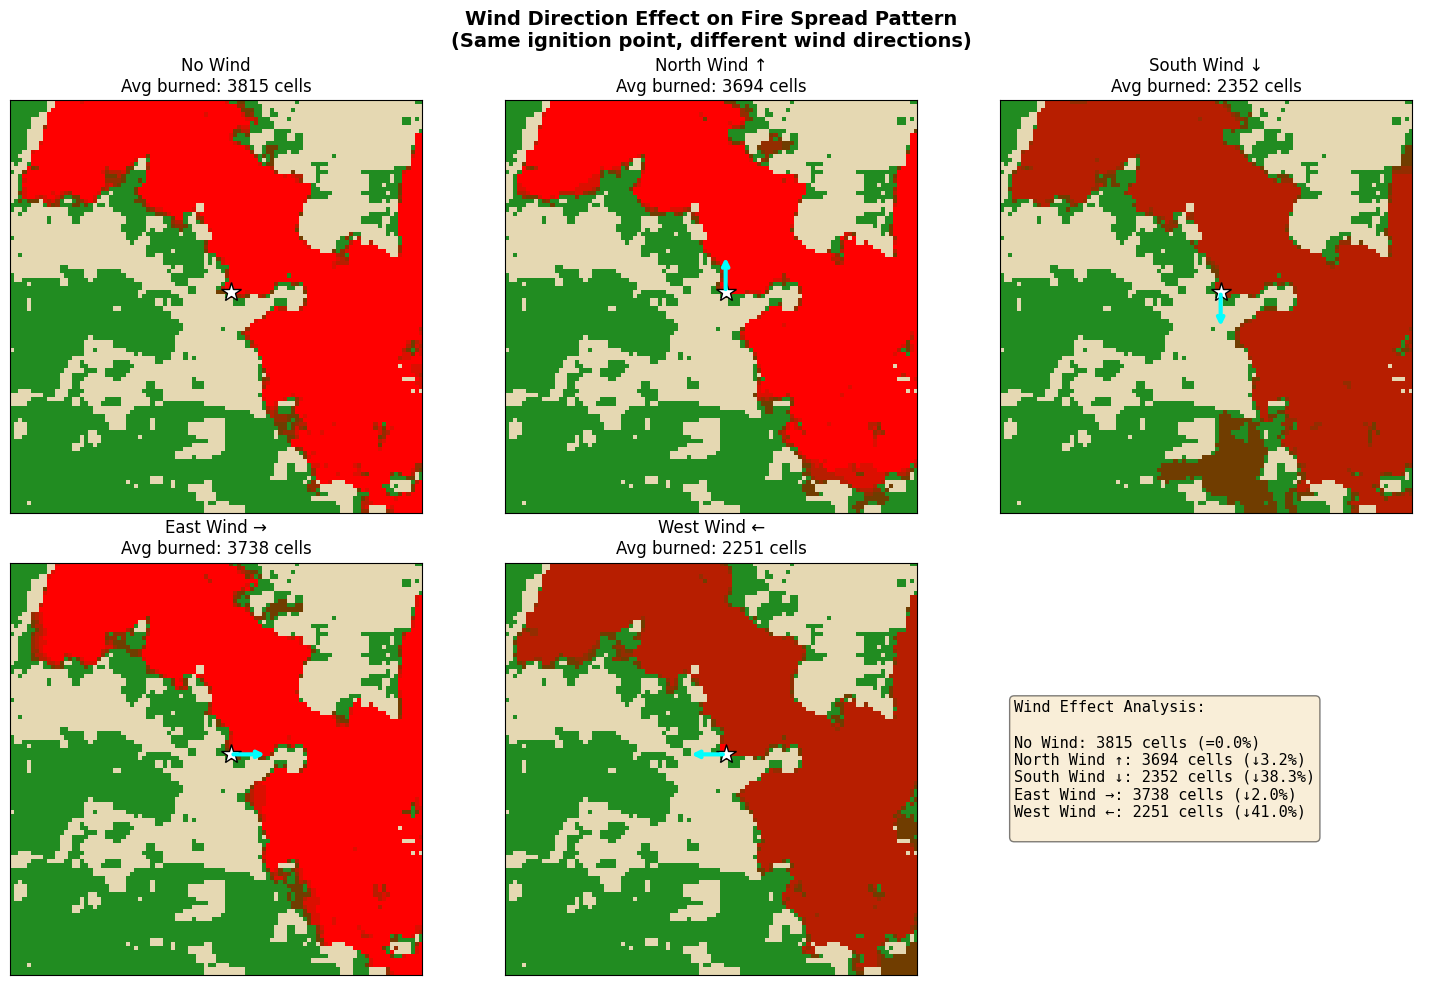

In [5]:
# Final burn patterns with different wind directions

def compare_wind_directions_static(density, n_trials=5, wind_strength=0.6):
    """
    Run multiple simulations and show average burn patterns for different wind directions.
    """

    # Wind configurations: (angle, name, dx, dy for arrow)
    wind_configs = [
        (0, 'No Wind', 0, 0, 0),
        (90, 'North Wind ↑', 90, 0, 0.3),
        (270, 'South Wind ↓', 270, 0, -0.3),
        (0, 'East Wind →', 0, 0.3, 0),
        (180, 'West Wind ←', 180, -0.3, 0),
    ]

    # Find starting position
    good_cells = np.where(density > 0.5)
    if len(good_cells[0]) > 0:
        center_r, center_c = density.shape[0]//2, density.shape[1]//2
        distances = (good_cells[0] - center_r)**2 + (good_cells[1] - center_c)**2
        best_idx = np.argmin(distances)
        start_pos = (good_cells[0][best_idx], good_cells[1][best_idx])
    else:
        start_pos = (density.shape[0]//2, density.shape[1]//2)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    results = []

    for idx, (angle, name, wind_dir, dx, dy) in enumerate(wind_configs):
        if idx >= 5:
            break

        ax = axes[idx]

        # Run multiple simulations and accumulate burn probability
        burn_count = np.zeros(density.shape)
        total_burned = 0

        w_str = 0 if name == 'No Wind' else wind_strength

        for trial in range(n_trials):
            sim = FireSimulator(density, wind_dir=wind_dir, wind_strength=w_str)
            sim.reset()
            sim.ignite(start_pos[0], start_pos[1])
            sim.run()
            burn_count += (sim.grid == BURNED)
            total_burned += np.sum(sim.grid == BURNED)

        burn_prob = burn_count / n_trials
        avg_burned = total_burned / n_trials

        # Create visualization using vectorized operations just to be faster
        display = np.zeros((*density.shape, 3))

        # Base colors
        forest_mask = density > 0
        clearing_mask = density == 0
        burned_mask = burn_prob > 0

        # Set forest green for unburned areas
        display[forest_mask, 0] = 0.13
        display[forest_mask, 1] = 0.55
        display[forest_mask, 2] = 0.13

        # Set tan for clearings
        display[clearing_mask, 0] = 0.9
        display[clearing_mask, 1] = 0.85
        display[clearing_mask, 2] = 0.7

        # Overlay burn probability (orange to red) - VECTORIZED
        display[burned_mask, 0] = 0.3 + 0.7 * burn_prob[burned_mask]
        display[burned_mask, 1] = 0.3 * (1 - burn_prob[burned_mask])
        display[burned_mask, 2] = 0

        ax.imshow(display)
        ax.plot(start_pos[1], start_pos[0], 'w*', markersize=15, markeredgecolor='black', markeredgewidth=1)

        # Draw wind arrow
        if dx != 0 or dy != 0:
            arrow_scale = min(density.shape) * 0.3
            ax.annotate('',
                       xy=(start_pos[1] + dx*arrow_scale, start_pos[0] - dy*arrow_scale),
                       xytext=(start_pos[1], start_pos[0]),
                       arrowprops=dict(arrowstyle='->', color='cyan', lw=3))

        ax.set_title(f'{name}\nAvg burned: {avg_burned:.0f} cells', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        results.append((name, avg_burned))

    axes[5].axis('off')

    # Add analysis text in the 6th subplot area
    analysis_text = "Wind Effect Analysis:\n\n"
    baseline = results[0][1]
    for name, burned in results:
        pct_change = ((burned - baseline) / baseline * 100) if baseline > 0 else 0
        direction = "↑" if pct_change > 0 else "↓" if pct_change < 0 else "="
        analysis_text += f"{name}: {burned:.0f} cells ({direction}{abs(pct_change):.1f}%)\n"

    axes[5].text(0.1, 0.5, analysis_text, transform=axes[5].transAxes, fontsize=11, verticalalignment='center', fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle('Wind Direction Effect on Fire Spread Pattern\n(Same ignition point, different wind directions)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return results

print("Running wind direction comparison (5 trials per direction)")

wind_results = compare_wind_directions_static(tree_density, n_trials=5, wind_strength=0.6)

## 4. Monte Carlo Simulation: Risk Map

To identify which areas face the highest wildfire risk, we do Monte Carlo simulation, running 500 independent fires from random ignition points and tracking outcomes. This approach is standard in percolation theory for characterizing stochastic processes on lattices [2].

In [6]:
def build_risk_map(density, n_trials=500, wind_dir=0, wind_strength=0.3):
    """
    Run many fires from random starting points.
    Track how often each cell burns or is next to burned cells.

    500 trials to get better coverage of the landscape. With 10,000 cells and
    random ignition, more trials = more complete risk picture.
    """
    rows, cols= density.shape
    burn_count = np.zeros((rows, cols))
    adjacent_count = np.zeros((rows, cols))

    sim = FireSimulator(density, wind_dir, wind_strength)

    for _ in tqdm(range(n_trials), desc="Running fires"):
        sim.reset()
        sim.ignite_random()
        sim.run()

        burned = (sim.grid == BURNED)
        burn_count += burned

        # Count cells adjacent to burned areas (no toroidal wrapping!)
        # Use padding to properly handle edges
        padded = np.pad(burned, 1, mode='constant', constant_values=False)
        adjacent = burned.copy()
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                # Extract shifted view from padded array
                shifted = padded[1+dr:rows+1+dr, 1+dc:cols+1+dc]
                adjacent = adjacent | shifted
        adjacent_count += adjacent

    burn_prob = burn_count / n_trials
    adjacent_prob = adjacent_count / n_trials

    return burn_prob, adjacent_prob

# Build the risk map with MORE simulations for better coverage
print("Building risk map (500 simulations for better coverage)")
burn_prob, adjacent_prob = build_risk_map(tree_density, n_trials=500)

Building risk map (500 simulations for better coverage)


Running fires:   0%|          | 0/500 [00:00<?, ?it/s]

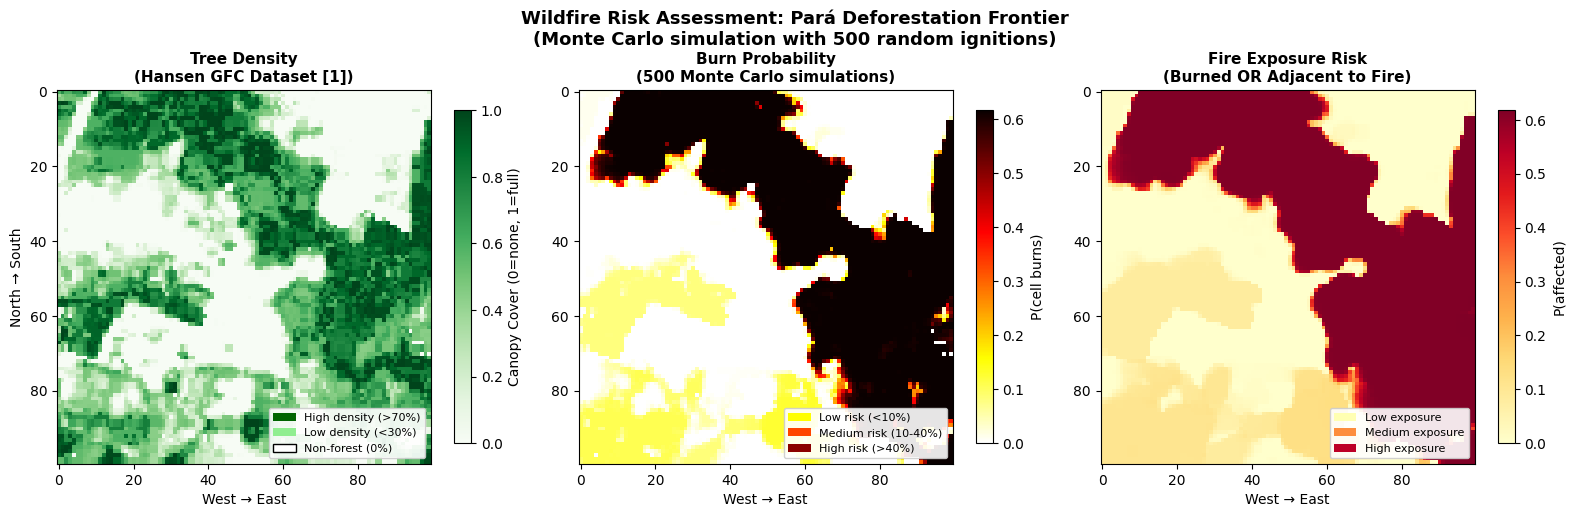

RISK MAP STATISTICS (500 simulations)
 Mean burn probability: 0.248
 Max burn probability: 0.616
 Mean adjacent risk: 0.288
 Cells with >50% burn risk: 3675
 Cells with zero burn risk: 3421 (34.2%)


In [7]:
# Wildfire Risk Map Visualization
# Three-panel figure showing:
# 1. Input landscape (tree density from Hansen dataset [1])
# 2. Burn probability (Monte Carlo results from 500 simulations)
# 3. Adjacent risk (burned + adjacent to burned)
#
# Color interpretation:
# - Green: Forest with fuel
# - Hot colors (yellow→red→black): Increasing burn probability

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# PANEL 1: Tree Density (Input Data)
# Source: Hansen Global Forest Change dataset [1]
im1 = axes[0].imshow(tree_density, cmap='Greens', vmin=0, vmax=1)
axes[0].set_title('Tree Density\n(Hansen GFC Dataset [1])', fontsize=11, fontweight='bold')
axes[0].set_xlabel('West → East')
axes[0].set_ylabel('North → South')
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label('Canopy Cover (0=none, 1=full)')

# Add legend annotations
from matplotlib.patches import Patch
legend_elements_1 = [
    Patch(facecolor='#006400', label='High density (>70%)'),
    Patch(facecolor='#90EE90', label='Low density (<30%)'),
    Patch(facecolor='white', edgecolor='black', label='Non-forest (0%)')
]
axes[0].legend(handles=legend_elements_1, loc='lower right', fontsize=8, framealpha=0.9)

# PANEL 2: Burn Probability
# Shows how often each cell burned across 500 Monte Carlo simulations
# Hot colormap: yellow (low) → red → black (high probability)
im2 = axes[1].imshow(burn_prob, cmap='hot_r', vmin=0, vmax=burn_prob.max())
axes[1].set_title('Burn Probability\n(500 Monte Carlo simulations)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('West → East')
cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.8)
cbar2.set_label('P(cell burns)')

# Add legend explaining colors
legend_elements_2 = [
    Patch(facecolor='#FFFF00', label='Low risk (<10%)'),
    Patch(facecolor='#FF4500', label='Medium risk (10-40%)'),
    Patch(facecolor='#8B0000', label='High risk (>40%)')
]
axes[1].legend(handles=legend_elements_2, loc='lower right', fontsize=8, framealpha=0.9)

# PANEL 3: Adjacent Risk (Broader Exposure Measure)
# Probability of being burned OR being adjacent to a burned cell
# Captures cells at risk even if they don't directly burn
im3 = axes[2].imshow(adjacent_prob, cmap='YlOrRd', vmin=0, vmax=adjacent_prob.max())
axes[2].set_title('Fire Exposure Risk\n(Burned OR Adjacent to Fire)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('West → East')
cbar3 = plt.colorbar(im3, ax=axes[2], shrink=0.8)
cbar3.set_label('P(affected)')

legend_elements_3 = [
    Patch(facecolor='#FFFFB2', label='Low exposure'),
    Patch(facecolor='#FD8D3C', label='Medium exposure'),
    Patch(facecolor='#BD0026', label='High exposure')
]
axes[2].legend(handles=legend_elements_3, loc='lower right', fontsize=8, framealpha=0.9)

plt.suptitle('Wildfire Risk Assessment: Pará Deforestation Frontier\n' +
             '(Monte Carlo simulation with 500 random ignitions)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print("RISK MAP STATISTICS (500 simulations)")
print(f" Mean burn probability: {burn_prob.mean():.3f}")
print(f" Max burn probability: {burn_prob.max():.3f}")
print(f" Mean adjacent risk: {adjacent_prob.mean():.3f}")
print(f" Cells with >50% burn risk: {(burn_prob > 0.5).sum()}")
print(f" Cells with zero burn risk: {(burn_prob == 0).sum()} ({(burn_prob == 0).mean()*100:.1f}%)")


Convergence check:   0%|          | 0/1000 [00:00<?, ?it/s]

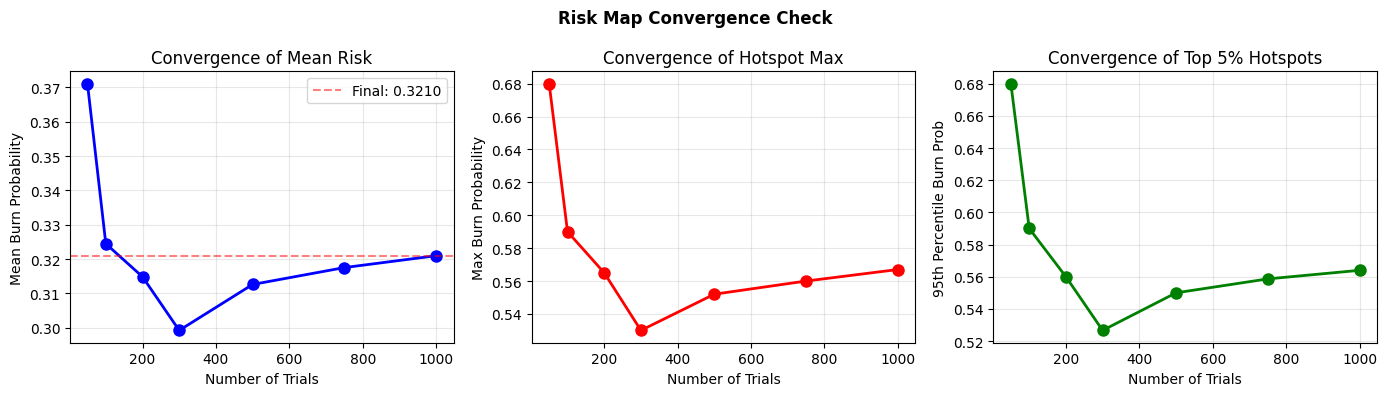


✓ Convergence Assessment:
 Mean burn probability at 200 trials: 0.3149
 Mean burn probability at 500 trials: 0.3210
 Relative change (200→500): 1.9%
Risk map has stabilized (change < 5%)


In [15]:
# Convergence check
# This verifies that 500 trials is sufficient for reliable estimates

def convergence_check(density, trial_counts=[50, 100, 200, 300, 500], wind_strength=0.3):
    """
    Run risk map calculation for different numbers of trials and track how key statistics converge.
    """
    results = {'n_trials': [], 'mean_burn_prob': [], 'max_burn_prob': [], 'hotspot_95': []}

    sim = FireSimulator(density, wind_dir=0, wind_strength=wind_strength)
    burn_count = np.zeros_like(density)

    trial_idx = 0
    max_trials = max(trial_counts)

    for t in tqdm(range(max_trials), desc="Convergence check"):
        sim.reset()
        sim.ignite_random()
        sim.run()
        burn_count += (sim.grid == BURNED)
        trial_idx += 1

        if trial_idx in trial_counts:
            burn_prob = burn_count / trial_idx
            fuel_mask = density > 0
            results['n_trials'].append(trial_idx)
            results['mean_burn_prob'].append(burn_prob[fuel_mask].mean())
            results['max_burn_prob'].append(burn_prob.max())
            results['hotspot_95'].append(np.percentile(burn_prob[fuel_mask], 95))

    return results

conv = convergence_check(tree_density, trial_counts=[50, 100, 200, 300, 500, 750, 1000])

# Plot convergence
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(conv['n_trials'], conv['mean_burn_prob'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Trials')
axes[0].set_ylabel('Mean Burn Probability')
axes[0].set_title('Convergence of Mean Risk')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(conv['mean_burn_prob'][-1], color='red', linestyle='--', alpha=0.5, label=f'Final: {conv["mean_burn_prob"][-1]:.4f}')
axes[0].legend()

axes[1].plot(conv['n_trials'], conv['max_burn_prob'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Trials')
axes[1].set_ylabel('Max Burn Probability')
axes[1].set_title('Convergence of Hotspot Max')
axes[1].grid(True, alpha=0.3)

axes[2].plot(conv['n_trials'], conv['hotspot_95'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Trials')
axes[2].set_ylabel('95th Percentile Burn Prob')
axes[2].set_title('Convergence of Top 5% Hotspots')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Risk Map Convergence Check', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Check relative change from 200 to 500 trials
change_mean = abs(conv['mean_burn_prob'][-1] - conv['mean_burn_prob'][2]) / conv['mean_burn_prob'][2] * 100
change_max = abs(conv['max_burn_prob'][-1] - conv['max_burn_prob'][2]) / conv['max_burn_prob'][2] * 100

print(f"\n✓ Convergence Assessment:")
print(f" Mean burn probability at 200 trials: {conv['mean_burn_prob'][2]:.4f}")
print(f" Mean burn probability at 500 trials: {conv['mean_burn_prob'][-1]:.4f}")
print(f" Relative change (200→500): {change_mean:.1f}%")
if change_mean < 5:
    print(f"Risk map has stabilized (change < 5%)")
else:
    print(f"Consider using more trials for better convergence")

In [9]:
# These tests ensure our adjacency calculation handles edges correctly
def test_adjacency_no_wraparound():
    """
    Test 1: Verify no wraparound on edges.
    If a cell burns in corner, only its actual neighbors should be marked adjacent.
    """
    # Create a small 5x5 grid with only top-left corner burned
    burned = np.zeros((5, 5), dtype=bool)
    burned[0, 0] = True  # Only top-left cell burned

    # Calculate adjacency using the correct method (np.pad)
    rows, cols = burned.shape
    padded = np.pad(burned, 1, mode='constant', constant_values=False)
    adjacent = burned.copy()
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            shifted = padded[1+dr:rows+1+dr, 1+dc:cols+1+dc]
            adjacent = adjacent | shifted

    # Expected: Only cells (0,0), (0,1), (1,0), (1,1) should be marked
    # The wrong method (np.roll) would also mark bottom-right corner area
    expected_adjacent = np.zeros((5, 5), dtype=bool)
    expected_adjacent[0, 0] = True # The burned cell itself
    expected_adjacent[0, 1] = True # Right neighbor
    expected_adjacent[1, 0] = True # Bottom neighbor
    expected_adjacent[1, 1] = True # Diagonal neighbor

    assert np.array_equal(adjacent, expected_adjacent), \
        f"Test 1 FAILED: Adjacency calculation has wraparound!\n" \
        f"Got:\n{adjacent.astype(int)}\nExpected:\n{expected_adjacent.astype(int)}"
    print("✅ Test 1 PASSED: No wraparound on corner burn")
    return True

def test_adjacency_bottom_right_corner():
    """
    Test 2: Verify no wraparound for bottom-right corner.
    """
    burned = np.zeros((5, 5), dtype=bool)
    burned[4, 4] = True # Only bottom-right cell burned

    rows, cols = burned.shape
    padded = np.pad(burned, 1, mode='constant', constant_values=False)
    adjacent = burned.copy()
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            shifted = padded[1+dr:rows+1+dr, 1+dc:cols+1+dc]
            adjacent = adjacent | shifted

    # Should only mark (4,4), (3,4), (4,3), (3,3)
    expected_adjacent = np.zeros((5, 5), dtype=bool)
    expected_adjacent[4, 4] = True
    expected_adjacent[3, 4] = True
    expected_adjacent[4, 3] = True
    expected_adjacent[3, 3] = True

    assert np.array_equal(adjacent, expected_adjacent), \
        f"Test 2 FAILED: Adjacency calculation has wraparound on bottom-right!"
    print("✅ Test 2 PASSED: No wraparound on bottom-right corner")
    return True

def test_adjacency_edge_burn():
    """
    Test 3: Verify edge burns don't wrap to opposite edge.
    Burn entire left edge and check right edge isn't affected.
    """
    burned = np.zeros((5, 5), dtype=bool)
    burned[:, 0] = True # Entire left edge burned

    rows, cols = burned.shape
    padded = np.pad(burned, 1, mode='constant', constant_values=False)
    adjacent = burned.copy()
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            shifted = padded[1+dr:rows+1+dr, 1+dc:cols+1+dc]
            adjacent = adjacent | shifted

    # Column 0 and 1 should be adjacent, but column 4 (rightmost) should not
    assert adjacent[:, 4].sum() == 0, \
        f"Test 3 FAILED: Right edge incorrectly marked as adjacent to left edge burn!"
    assert adjacent[:, 0].all() and adjacent[:, 1].all(), \
        f"Test 3 FAILED: Left edge neighbors not correctly marked!"
    print("✅ Test 3 PASSED: Edge burn doesn't wrap to opposite side")
    return True

def test_np_roll_is_wrong():
    """
    Test 4: Demonstrate that np.roll WOULD give wrong results.
    This shows why we need np.pad instead.
    """
    burned = np.zeros((5, 5), dtype=bool)
    burned[0, 0] = True # Only top-left burned

    # Wrong method using np.roll (toroidal/wrap-around)
    adjacent_wrong = burned.copy()
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            shifted = np.roll(np.roll(burned, dr, axis=0), dc, axis=1)
            adjacent_wrong = adjacent_wrong | shifted

    # np.roll wraps around, so (4,4), (4,0), (0,4) will also be marked!
    wrong_artifacts = adjacent_wrong[4, 4] or adjacent_wrong[4, 0] or adjacent_wrong[0, 4]

    assert wrong_artifacts, \
        "Test 4: np.roll should have wraparound artifacts (this test verifies the bug exists)"
    print("✅ Test 4 PASSED: Confirmed np.roll causes wraparound artifacts (which we avoid!)")
    return True

# Run all tests
print("=" * 60)
print("RUNNING ADJACENCY CALCULATION TESTS")
print("=" * 60)
all_passed = True
all_passed &= test_adjacency_no_wraparound()
all_passed &= test_adjacency_bottom_right_corner()
all_passed &= test_adjacency_edge_burn()
all_passed &= test_np_roll_is_wrong()

if all_passed:
    print(" All tests passed.So Adjacency calculation is correct.")
else:
    print("Some tests failed.")


RUNNING ADJACENCY CALCULATION TESTS
✅ Test 1 PASSED: No wraparound on corner burn
✅ Test 2 PASSED: No wraparound on bottom-right corner
✅ Test 3 PASSED: Edge burn doesn't wrap to opposite side
✅ Test 4 PASSED: Confirmed np.roll causes wraparound artifacts (which we avoid!)
 All tests passed.So Adjacency calculation is correct.


## 5. Phase Transition in Fire Spread

In [10]:
def percolation_analysis(density, scale_values, n_trials=50):
    """
    Test how fire behavior changes as we scale density up/down.
    This finds the percolation threshold.
    """
    results = {
        'scale': [], 'span_prob': [],
        'burned_mean': [], 'burned_std': []
    }

    for s in tqdm(scale_values, desc="Testing scales"):
        scaled = np.clip(s * density, 0, 1)

        spans = 0
        burned_list = []

        sim = FireSimulator(scaled, wind_dir=0, wind_strength=0.3)

        for _ in range(n_trials):
            sim.reset()
            sim.ignite_west_edge()
            sim.run()

            spans += sim.did_span_horizontal()
            burned_list.append(sim.burned_fraction())

        results['scale'].append(s)
        results['span_prob'].append(spans / n_trials)
        results['burned_mean'].append(np.mean(burned_list))
        results['burned_std'].append(np.std(burned_list))

    return results

# Run the percolation sweep
scales = np.linspace(0.3, 2.0, 20)
perc = percolation_analysis(tree_density, scales, n_trials=50)

Testing scales:   0%|          | 0/20 [00:00<?, ?it/s]

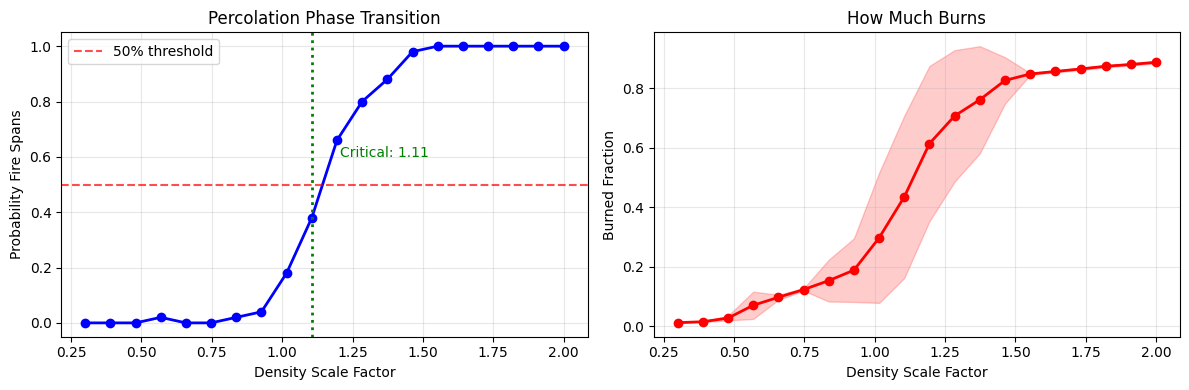


Critical threshold: scale = 1.11
Below this, fires stay small. Above this, fires can spread everywhere.


In [11]:
# Plot the percolation results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

scale = np.array(perc['scale'])
span_prob = np.array(perc['span_prob'])
burned_mean = np.array(perc['burned_mean'])
burned_std = np.array(perc['burned_std'])

# Spanning probability shows the phase transition
axes[0].plot(scale, span_prob, 'bo-', linewidth=2)
axes[0].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='50% threshold')
axes[0].set_xlabel('Density Scale Factor')
axes[0].set_ylabel('Probability Fire Spans')
axes[0].set_title('Percolation Phase Transition')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Find and mark the critical point
if span_prob.max() > 0.5 and span_prob.min() < 0.5:
    crit_idx = np.argmin(np.abs(span_prob - 0.5))
    crit_scale = scale[crit_idx]
    axes[0].axvline(crit_scale, color='green', linestyle=':', linewidth=2)
    axes[0].text(crit_scale + 0.1, 0.6, f'Critical: {crit_scale:.2f}', color='green')

# Burned fraction
axes[1].plot(scale, burned_mean, 'ro-', linewidth=2)
axes[1].fill_between(scale, burned_mean - burned_std, burned_mean + burned_std, color='red', alpha=0.2)
axes[1].set_xlabel('Density Scale Factor')
axes[1].set_ylabel('Burned Fraction')
axes[1].set_title('How Much Burns')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if span_prob.max() > 0.5 and span_prob.min() < 0.5:
    print(f"\nCritical threshold: scale = {crit_scale:.2f}")
    print("Below this, fires stay small. Above this, fires can spread everywhere.")

## 6. Comparing Fire Management Strategies

We compare **two genuinely different resource allocation strategies**.

### Strategy 1: Strategic Prescribed Burns (Proactive)

### Strategy 2: Rapid Response Teams (Reactive)

In [12]:
def identify_critical_corridors(density, target_fraction=0.05):
    """
    Identify cells frequently involved in large fires using simulation.
    """
    rows, cols = density.shape

    # Run many simulations and track which cells burn in LARGE fires
    burn_frequency = np.zeros_like(density)
    large_fire_threshold = 0.1 # Consider fires that burn >10% as "large"

    sim = FireSimulator(density, wind_dir=0, wind_strength=0.3)
    n_large_fires = 0

    for _ in range(100):
        sim.reset()
        sim.ignite_random()
        sim.run()

        burned_frac = sim.burned_fraction()
        if burned_frac > large_fire_threshold:
            # This was a large fire, these burned cells are "critical"
            burn_frequency += (sim.grid == BURNED)
            n_large_fires += 1

    print(f"  Found {n_large_fires} large fires (>{large_fire_threshold*100:.0f}% burned)")

    if n_large_fires == 0:
        # Target highest density cells at patch edges
        from scipy import ndimage
        edges = ndimage.sobel(density)
        corridor_score = np.abs(edges) * density
    else:
        # Normalize to get probability
        corridor_score = burn_frequency / max(n_large_fires, 1)

    # Only consider cells with actual fuel
    corridor_score[density < 0.3] = 0

    # Select top cells for prescribed burning
    n_cells_to_burn = int(target_fraction * np.sum(density > 0))

    flat_indices = np.argsort(corridor_score.ravel())[::-1]
    burn_mask = np.zeros_like(density, dtype=bool)

    count = 0
    for idx in flat_indices:
        if count >= n_cells_to_burn:
            break
        i, j = idx // cols, idx % cols
        if density[i, j] >= 0.3 and corridor_score[i, j] > 0:
            burn_mask[i, j] = True
            count += 1
    return burn_mask, corridor_score


def run_with_prescribed_burns(density, target_fraction=0.05, n_trials=200, wind_strength=0.3):
    """
    Simulate fires after strategic prescribed burns.
    """
    burn_mask, corridor_score = identify_critical_corridors(density, target_fraction)

    modified_density = density.copy()
    modified_density[burn_mask] = 0 # Prescribed burn removes fuel

    n_burned = np.sum(burn_mask)
    n_vegetated = np.sum(density > 0)
    print(f"  Pre-burned: {n_burned} cells ({100*n_burned/n_vegetated:.1f}% of vegetated area)")

    burned_list = []
    sim = FireSimulator(modified_density, wind_dir=0, wind_strength=wind_strength)

    for _ in tqdm(range(n_trials), desc=f"Prescribed burns ({target_fraction*100:.0f}%)"):
        sim.reset()
        sim.ignite_random()
        sim.run()
        burned_list.append(sim.burned_fraction())

    return np.array(burned_list), modified_density, corridor_score


def run_with_rapid_response(density, response_threshold, n_trials=200, wind_strength=0.3,
                             suppression_efficiency=0.85):
    """
    Simulate fires with rapid response teams.

    When threshold is reached, we model "containment":
    All currently burning cells are converted to BURNED (fire doesn't magically disappear)
    Suppression_efficiency controls what fraction of BURNING cells are actually contained
    (some may escape and continue spreading for one more step)

    This fixes the bias where stopping early without counting burning cells would
    underestimate damage from rapid response.
    """
    burned_list = []
    sim = FireSimulator(density, wind_dir=0, wind_strength=wind_strength)

    for _ in tqdm(range(n_trials), desc=f"Rapid response ({response_threshold} cells)"):
        sim.reset()
        sim.ignite_random()

        while True:
            active = sim.step()
            burned_count = np.sum(sim.grid == BURNED)
            burning_count = np.sum(sim.grid == BURNING)

            if burned_count >= response_threshold:
                # Convert all burning cells to burned
                # This represents fire being stopped from spreading further, but
                # already-burning fuel still burns out

                # Some burning cells may escape containment
                burning_cells = np.where(sim.grid == BURNING)
                for r, c in zip(burning_cells[0], burning_cells[1]):
                    if np.random.random() < suppression_efficiency:
                        sim.grid[r, c] = BURNED # Contained, burns out
                    # else: stays burning, will spread one more time

                # Let escaped fires spread one more step
                if np.sum(sim.grid == BURNING) > 0:
                    sim.step()
                    # Final containment of any remaining
                    sim.grid[sim.grid == BURNING] = BURNED
                break
            if not active:
                break

        burned_list.append(sim.burned_fraction())

    return np.array(burned_list)


# Compare the strategies
print(" Comparison: Prescribed Burns vs Rapid Response")

# Baseline: no intervention
baseline_burned = run_with_rapid_response(tree_density, response_threshold=100000, n_trials=200)

# Strategy 1: Strategic prescribed burns (10% of landscape - more aggressive)
prescribed_burned, prescribed_density, corridor_scores = run_with_prescribed_burns(tree_density, target_fraction=0.10, n_trials=200)

# Strategy 2: Rapid response (detect at 400 cells - realistic for remote Amazon)
# 400 cells =  apprx 36 hectares, accounts for satellite detection delay + crew deployment time
response_burned = run_with_rapid_response(tree_density, response_threshold=400, n_trials=200,
                                          suppression_efficiency=0.85)

strategy_results = {'No Intervention': {'burned': baseline_burned, 'density': tree_density},
    'Prescribed Burns (10%)': {'burned': prescribed_burned, 'density': prescribed_density},
    'Rapid Response (400 cells)': {'burned': response_burned, 'density': tree_density},
}

 Comparison: Prescribed Burns vs Rapid Response


Rapid response (100000 cells):   0%|          | 0/200 [00:00<?, ?it/s]

  Found 65 large fires (>10% burned)
  Pre-burned: 720 cells (10.0% of vegetated area)


Prescribed burns (10%):   0%|          | 0/200 [00:00<?, ?it/s]

Rapid response (400 cells):   0%|          | 0/200 [00:00<?, ?it/s]

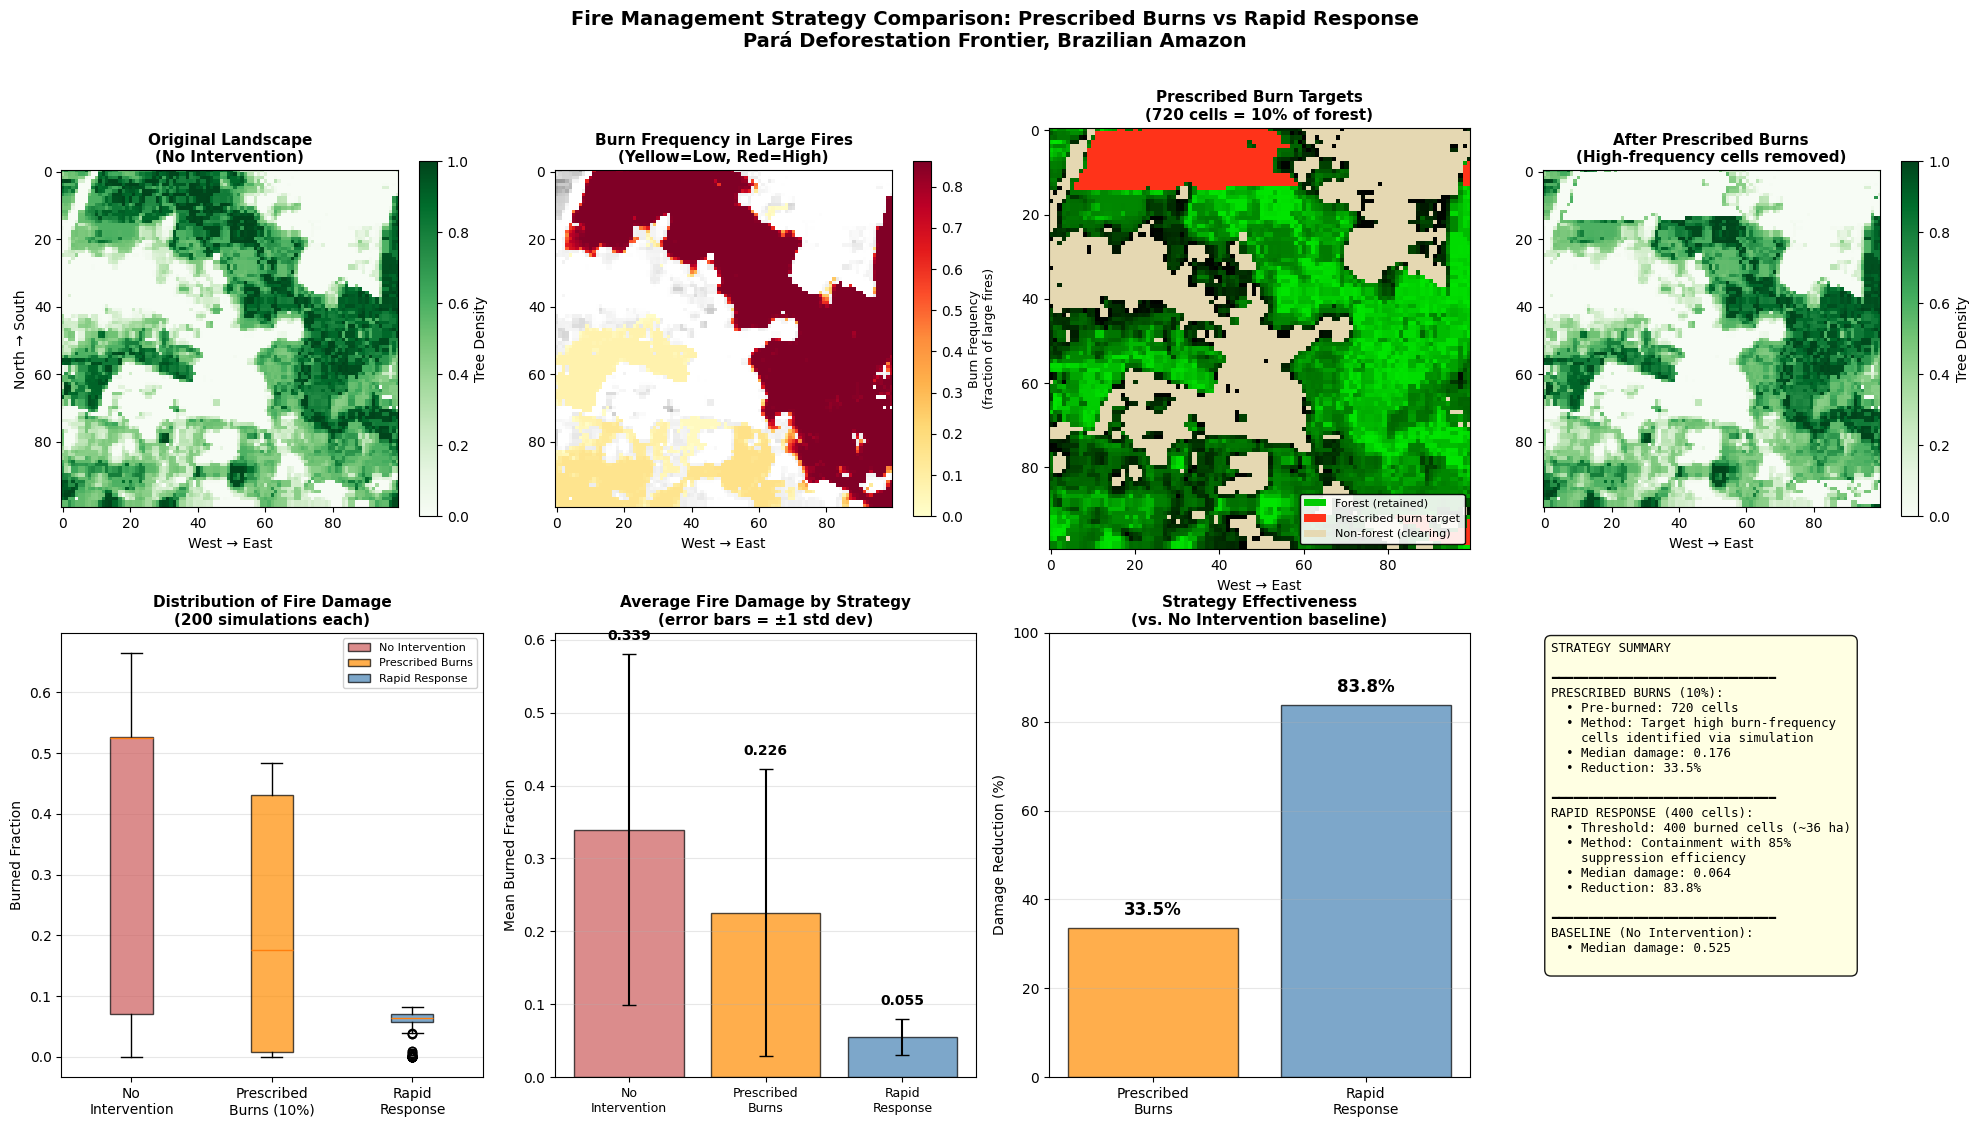

Strategy                            Mean         Median       Std Dev     
----------------------------------------------------------------------
No Intervention                     0.3393       0.5246       0.2411
Prescribed Burns (10%)              0.2257       0.1756       0.1969
Rapid Response (400 cells)          0.0549       0.0640       0.0250

----------------------------------------------------------------------

  PRESCRIBED BURNS reduce damage by 33.5% vs no intervention
  RAPID RESPONSE reduces damage by 83.8% vs no intervention

  → RAPID RESPONSE is more effective by 50.4 percentage points


In [13]:
# Comparison Visualization
# Creates an 8-panel figure comparing fire management strategies.
# Visualization approach follows Matplotlib best practices [4] with clear legends,
# colorbars, and annotations for interpretability.
#
# Top row: Landscape analysis (density maps and treatment targets)
# Bottom row: Statistical results (box plots, bar charts, effectiveness)

fig = plt.figure(figsize=(20, 11))

# PANEL 1: Original Landscape (No Intervention)
# Shows tree density from Hansen GFC dataset [1]
ax1 = fig.add_subplot(2, 4, 1)
im1 = ax1.imshow(tree_density, cmap='Greens', vmin=0, vmax=1)
ax1.set_title('Original Landscape\n(No Intervention)', fontsize=11, fontweight='bold')
ax1.set_xlabel('West → East')
ax1.set_ylabel('North → South')
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, label='Tree Density')

# PANEL 2: Burn Frequency Map (IMPROVED)
# Shows which cells burn frequently in large fires (>10% of landscape)
ax2 = fig.add_subplot(2, 4, 2)

# Create a better visualization with masked array for NaN handling
corridor_display = np.ma.masked_where(corridor_scores == 0, corridor_scores)

# Show base landscape in gray for context
ax2.imshow(tree_density, cmap='Greys', vmin=0, vmax=1, alpha=0.4)

im2 = ax2.imshow(corridor_display, cmap='YlOrRd', vmin=0, vmax=corridor_scores.max())
ax2.set_title('Burn Frequency in Large Fires\n(Yellow=Low, Red=High)', fontsize=11, fontweight='bold')
ax2.set_xlabel('West → East')

cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Burn Frequency\n(fraction of large fires)', fontsize=9)

# PANEL 3: Prescribed Burn Target Areas
# Red cells = targeted for prescribed burning (top 10% burn frequency)
# Green cells = remaining forest (not targeted)
# Tan/beige = non-forest areas (clearings, water)

ax3 = fig.add_subplot(2, 4, 3)

# Create RGB image for clear color coding
display_prescribed = np.zeros((*tree_density.shape, 3))

# Forest cells (not targeted) → Green
forest_not_targeted = (tree_density > 0) & (prescribed_density > 0)
display_prescribed[forest_not_targeted, 1] = tree_density[forest_not_targeted] * 0.9

# Non-forest areas → Tan/beige
display_prescribed[tree_density == 0] = [0.9, 0.85, 0.7]

# Prescribed burn targets → Bright red
burn_mask = (tree_density > 0) & (prescribed_density == 0)
display_prescribed[burn_mask] = [1.0, 0.2, 0.1]

ax3.imshow(display_prescribed)
ax3.set_title(f'Prescribed Burn Targets\n({np.sum(burn_mask)} cells = 10% of forest)', fontsize=11, fontweight='bold')
ax3.set_xlabel('West → East')

from matplotlib.patches import Patch
legend_elements_3 = [
    Patch(facecolor='#00CC00', label='Forest (retained)'),
    Patch(facecolor='#FF3319', label='Prescribed burn target'),
    Patch(facecolor='#E6D9B3', label='Non-forest (clearing)')]
ax3.legend(handles=legend_elements_3, loc='lower right', fontsize=8, framealpha=0.9, edgecolor='black')

# PANEL 4: Landscape After Prescribed Burns
# Shows the modified landscape with high-frequency cells removed
ax4 = fig.add_subplot(2, 4, 4)
im4 = ax4.imshow(prescribed_density, cmap='Greens', vmin=0, vmax=1)
ax4.set_title('After Prescribed Burns\n(High-frequency cells removed)', fontsize=11, fontweight='bold')
ax4.set_xlabel('West → East')
cbar4 = plt.colorbar(im4, ax=ax4, shrink=0.8, label='Tree Density')

# PANEL 5: Box Plot of Fire Damage Distribution
ax5 = fig.add_subplot(2, 4, 5)
colors_list = ['#CD5C5C', '#FF8C00', '#4682B4']
names = list(strategy_results.keys())
data_to_plot = [strategy_results[n]['burned'] for n in names]

bp = ax5.boxplot(data_to_plot, patch_artist=True, tick_labels=['No\nIntervention', 'Prescribed\nBurns (10%)', 'Rapid\nResponse'])

# Color the boxes and add legend
for i, (patch, color) in enumerate(zip(bp['boxes'], colors_list)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')

ax5.set_ylabel('Burned Fraction', fontsize=10)
ax5.set_title('Distribution of Fire Damage\n(200 simulations each)', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

legend_elements_5 = [
    Patch(facecolor=colors_list[0], alpha=0.7, label='No Intervention', edgecolor='black'),
    Patch(facecolor=colors_list[1], alpha=0.7, label='Prescribed Burns', edgecolor='black'),
    Patch(facecolor=colors_list[2], alpha=0.7, label='Rapid Response', edgecolor='black')]
ax5.legend(handles=legend_elements_5, loc='upper right', fontsize=8, framealpha=0.9)

# PANEL 6: Bar Chart of Mean Damage (with error bars)
# Error bars show ±1 standard deviation
# Numeric labels show exact mean values
ax6 = fig.add_subplot(2, 4, 6)
means = [strategy_results[n]['burned'].mean() for n in names]
stds = [strategy_results[n]['burned'].std() for n in names]

x = np.arange(len(names))
bars = ax6.bar(x, means, yerr=stds, color=colors_list, alpha=0.7, capsize=5, edgecolor='black', linewidth=1)
ax6.set_ylabel('Mean Burned Fraction', fontsize=10)
ax6.set_title('Average Fire Damage by Strategy\n(error bars = ±1 std dev)', fontsize=11, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['No\nIntervention', 'Prescribed\nBurns', 'Rapid\nResponse'], fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean_val) in enumerate(zip(bars, means)):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 0.015,
             f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# PANEL 7: Strategy Effectiveness (% Damage Reduction)
# Shows percentage reduction in damage compared to no intervention baseline
ax7 = fig.add_subplot(2, 4, 7)
baseline_val = strategy_results['No Intervention']['burned'].mean()
reduction_keys = [n for n in names if n != 'No Intervention']
reductions = [(baseline_val - strategy_results[n]['burned'].mean()) / baseline_val * 100 for n in reduction_keys]

x2 = np.arange(len(reduction_keys))
bars2 = ax7.bar(x2, reductions, color=colors_list[1:], alpha=0.7, edgecolor='black', linewidth=1)
ax7.set_ylabel('Damage Reduction (%)', fontsize=10)
ax7.set_title('Strategy Effectiveness\n(vs. No Intervention baseline)', fontsize=11, fontweight='bold')
ax7.set_xticks(x2)
ax7.set_xticklabels(['Prescribed\nBurns', 'Rapid\nResponse'], fontsize=10)
ax7.grid(True, alpha=0.3, axis='y')
ax7.axhline(0, color='black', linewidth=0.5)
ax7.set_ylim(0, 100)

# Add percentage labels
for bar, val in zip(bars2, reductions):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# PANEL 8: Summary Statistics Text Box
ax8 = fig.add_subplot(2, 4, 8)
ax8.axis('off')

prescribed_cells = np.sum(burn_mask)
total_veg_cells = np.sum(tree_density > 0)

p50_baseline = np.percentile(strategy_results['No Intervention']['burned'], 50)
p50_prescribed = np.percentile(strategy_results[names[1]]['burned'], 50)
p50_response = np.percentile(strategy_results[names[2]]['burned'], 50)

# Formatted analysis text
analysis_text = f"""STRATEGY SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PRESCRIBED BURNS (10%):
  • Pre-burned: {prescribed_cells} cells
  • Method: Target high burn-frequency
    cells identified via simulation
  • Median damage: {p50_prescribed:.3f}
  • Reduction: {(baseline_val - strategy_results[names[1]]['burned'].mean()) / baseline_val * 100:.1f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
RAPID RESPONSE (400 cells):
  • Threshold: 400 burned cells (~36 ha)
  • Method: Containment with 85%
    suppression efficiency
  • Median damage: {p50_response:.3f}
  • Reduction: {(baseline_val - strategy_results[names[2]]['burned'].mean()) / baseline_val * 100:.1f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
BASELINE (No Intervention):
  • Median damage: {p50_baseline:.3f}
"""

ax8.text(0.02, 0.98, analysis_text, transform=ax8.transAxes, fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=1))

# Main title
plt.suptitle('Fire Management Strategy Comparison: Prescribed Burns vs Rapid Response\n' +
             'Pará Deforestation Frontier, Brazilian Amazon', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# Print comparison
print(f"{'Strategy':<35} {'Mean':<12} {'Median':<12} {'Std Dev':<12}")
print("-"*70)
for name, res in strategy_results.items():
    m = res['burned'].mean()
    med = np.median(res['burned'])
    s = res['burned'].std()
    print(f"{name:<35} {m:.4f}       {med:.4f}       {s:.4f}")

print("\n" + "-"*70)
baseline_mean = strategy_results['No Intervention']['burned'].mean()
prescribed_mean = strategy_results[names[1]]['burned'].mean()
response_mean = strategy_results[names[2]]['burned'].mean()

prescribed_reduction = (baseline_mean - prescribed_mean) / baseline_mean * 100
response_reduction = (baseline_mean - response_mean) / baseline_mean * 100

print(f"\n  PRESCRIBED BURNS reduce damage by {prescribed_reduction:.1f}% vs no intervention")
print(f"  RAPID RESPONSE reduces damage by {response_reduction:.1f}% vs no intervention")

if prescribed_reduction > response_reduction:
    winner = "PRESCRIBED BURNS"
    diff = prescribed_reduction - response_reduction
else:
    winner = "RAPID RESPONSE"
    diff = response_reduction - prescribed_reduction

print(f"\n  → {winner} is more effective by {diff:.1f} percentage points")

## 7. Uncertainty Analysis: 95% Confidence Intervals

In [14]:
def ci_mean(data, n_samples=1000, confidence=0.95):
    """
    Compute confidence interval for the mean
    """
    means = []
    n = len(data)
    for _ in range(n_samples):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(sample.mean())
    means = np.array(means)
    alpha = (1 - confidence) / 2
    ci_low = np.percentile(means, alpha * 100)
    ci_high = np.percentile(means, (1 - alpha) * 100)
    return ci_low, ci_high

def ci_diff(data_a, data_b, n_samples=10000, confidence=0.95):
    """
    Compute confidence interval for the DIFFERENCE in means (mean_A - mean_B)
    """
    diff_means = []
    n_a, n_b = len(data_a), len(data_b)
    for _ in range(n_samples):
        sample_a = np.random.choice(data_a, size=n_a, replace=True)
        sample_b = np.random.choice(data_b, size=n_b, replace=True)
        diff_means.append(sample_a.mean() - sample_b.mean())
    diff_means = np.array(diff_means)
    alpha = (1 - confidence) / 2
    ci_low = np.percentile(diff_means, alpha * 100)
    ci_high = np.percentile(diff_means, (1 - alpha) * 100)
    point_est = data_a.mean() - data_b.mean()
    return point_est, ci_low, ci_high

# Compute 95% CIs for each strategy's mean burned fraction
print("="*70)
print("95% Confidence Intervals for Mean Burned Fraction")
print("="*70)

ci_results = {}
names = list(strategy_results.keys())
for name in names:
    res = strategy_results[name]
    data = res['burned']
    mean = data.mean()
    ci_low, ci_high = ci_mean(data)
    width = ci_high - ci_low
    ci_results[name] = (ci_low, ci_high)
    print(f"{name}:")
    print(f"  Mean = {mean:.4f}")
    print(f"  95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    print(f"  CI width = {width:.4f}")
    print()

# Statistical significance tests using CI on the DIFFERENCE
print("Statistical Significance Tests (CI on Difference in Means)")

prescribed_name = names[1]
response_name = names[2]
baseline_name = names[0]

prescribed_data = strategy_results[prescribed_name]['burned']
response_data = strategy_results[response_name]['burned']
baseline_data = strategy_results[baseline_name]['burned']

# Test 1: Prescribed Burns vs Rapid Response
diff_est, ci_low, ci_high = ci_diff(prescribed_data, response_data)
excludes_zero = ci_low > 0 or ci_high < 0
print(f"1. Prescribed Burns vs Rapid Response:")
print(f" Difference (PB - RR) = {diff_est:.4f}")
print(f" 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
if excludes_zero:
    if ci_high < 0:
        print(f" Prescribed Burns significantly better (CI excludes zero)")
    else:
        print(f" Rapid Response significantly better (CI excludes zero)")
else:
    print(f" No significant difference (CI includes zero)")

# Test 2: Prescribed Burns vs No Intervention
diff_est, ci_low, ci_high = ci_diff(prescribed_data, baseline_data)
excludes_zero = ci_low > 0 or ci_high < 0
print(f"\n2. Prescribed Burns vs No Intervention:")
print(f" Difference (PB - None) = {diff_est:.4f}")
print(f" 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
if excludes_zero:
    if ci_high < 0:
        print(f" Prescribed Burns significantly reduces damage (CI excludes zero)")
    else:
        print(f" Prescribed Burns significantly increases damage (CI excludes zero)")
else:
    print(f" No significant difference from baseline (CI includes zero)")

# Test 3: Rapid Response vs No Intervention
diff_est, ci_low, ci_high = ci_diff(response_data, baseline_data)
excludes_zero = ci_low > 0 or ci_high < 0
print(f"\n3. Rapid Response vs No Intervention:")
print(f" Difference (RR - None) = {diff_est:.4f}")
print(f" 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
if excludes_zero:
    if ci_high < 0:
        print(f" Rapid Response significantly reduces damage (CI excludes zero)")
    else:
        print(f" Rapid Response significantly increases damage (CI excludes zero)")
else:
    print(f" No significant difference from baseline (CI includes zero)")

print()

95% Confidence Intervals for Mean Burned Fraction
No Intervention:
  Mean = 0.3393
  95% CI = [0.3048, 0.3716]
  CI width = 0.0668

Prescribed Burns (10%):
  Mean = 0.2257
  95% CI = [0.1989, 0.2525]
  CI width = 0.0536

Rapid Response (400 cells):
  Mean = 0.0549
  95% CI = [0.0514, 0.0584]
  CI width = 0.0070

Statistical Significance Tests (CI on Difference in Means)
1. Prescribed Burns vs Rapid Response:
 Difference (PB - RR) = 0.1709
 95% CI = [0.1440, 0.1982]
 Rapid Response significantly better (CI excludes zero)

2. Prescribed Burns vs No Intervention:
 Difference (PB - None) = -0.1136
 95% CI = [-0.1561, -0.0697]
 Prescribed Burns significantly reduces damage (CI excludes zero)

3. Rapid Response vs No Intervention:
 Difference (RR - None) = -0.2845
 95% CI = [-0.3189, -0.2501]
 Rapid Response significantly reduces damage (CI excludes zero)



## References

### Data Sources

1. **Hansen, M.C., et al. (2013).** High-Resolution Global Maps of 21st-Century Forest Cover Change. *Science*, 342(6160), 850-853.
   - Data URL: https://earthenginepartners.appspot.com/science-2013-global-forest
   - **Used in:** Section 1 (data loading), Section 4 (risk map), Section 8 (summary)
   - Provides 30-meter resolution tree canopy cover estimates for year 2000

### Theoretical References

2. **Stauffer, D. & Aharony, A. (1994).** *Introduction to Percolation Theory* (2nd ed.). Taylor & Francis.
   - **Used in:** Section 2 (model design), Section 4 (Monte Carlo approach), Section 5 (phase transition analysis)
   - Provides theoretical foundation for percolation threshold and critical phenomena

3. **CS166 Course Materials** - Modeling Complex Systems, UC San Diego
   - **Used in:** Section 2 (cellular automaton design), Section 6 (strategy comparison framework)
   - Provides framework for fire spread cellular automata and Monte Carlo simulation techniques

### Code References

4. **Matplotlib Documentation.** Tutorial.
   - URL: https://matplotlib.org/stable/users/explain/animations/animations.html
   - **Used in:** Section 3 (wind animation using FuncAnimation)

5. **NumPy Documentation.** Random sampling and array operations.
   - URL: https://numpy.org/doc/stable/reference/random/
   - **Used in:** Throughout (random ignition, Monte Carlo sampling)

6. **PIL/Pillow Documentation.** Image loading for GeoTIFF files.
   - URL: https://pillow.readthedocs.io/
   - **Used in:** Section 1 (loading Hansen GeoTIFF tiles)

### Code Methodology Notes

- **Sigmoid ignition function** (Section 2): Adapted from CS166 course materials [3] to create threshold behavior in fire spread probability
- **8-neighbor (Moore) connectivity**: Standard approach in cellular automata fire models [2, 3]
- **Monte Carlo risk assessment** (Section 4): Following percolation theory methodology [2]
- **Edge-handling in adjacency calculation**: Uses `np.pad` instead of `np.roll` to avoid toroidal (wrap-around) artifacts
- **Containment model for rapid response** (Section 6): Original implementation modeling 85% suppression efficiency